# How does genre factor into Movie Success
- Also, does genre/success depend on domestic vs abroad?

What datasets will this need?
- IMDB title basics for Genre Info
- TN Movie Budgets for domestic and worldwide gross

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

#datasets to dataframes
imdb_basics_df = pd.read_csv('zippedData\imdb.title.basics.csv.gz')
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


#Clean IMDB basics runtime_minutes
imdb_basics_df['runtime_minutes'].fillna(imdb_basics_df['runtime_minutes'].median(),inplace=True)
#Clean IMDB basics genres
imdb_basics_df['genres'].fillna('Genre Data Missing',inplace = True)
#Clean IMDB basics original_title
imdb_basics_df['original_title'].fillna(imdb_basics_df['primary_title'],inplace = True)

print(imdb_basics_df.info())

money_list = ['production_budget','domestic_gross','worldwide_gross']
for ser in money_list:
    tn_budgets_df[ser] = tn_budgets_df[ser].apply(lambda x:x.replace(',',''))
    tn_budgets_df[ser] = tn_budgets_df[ser].apply(lambda x:x.replace('$',''))
    tn_budgets_df[ser] = pd.to_numeric(tn_budgets_df[ser])

print(tn_budgets_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146144 non-null object
start_year         146144 non-null int64
runtime_minutes    146144 non-null float64
genres             146144 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null int64
domestic_gross       5782 non-null int64
worldwide_gross      5782 non-null int64
dtypes: int64(4), object(2)
memory usage: 271.2+ KB
None


Next question: How to combine datasets
- no id column in common
- TN: 'movie' has movie name
- IMDB basics: 'primary_title' (might also be worth comparing 'original_title')
- Original title does match in some cases Primary does not, added or clause
- Warning: cell below takes a *long* time to run.

In [17]:
from pandasql import sqldf
q = """SELECT primary_title, genres, domestic_gross, worldwide_gross, tconst
        FROM imdb_basics_df imdb
        JOIN tn_budgets_df tn
        ON (imdb.primary_title = tn.movie OR imdb.original_title = tn.movie)
        WHERE (domestic_gross >0 OR worldwide_gross > 0) AND genres != "Genre Data Missing";"""

results = sqldf(q)
results

,primary_title,genres,domestic_gross,worldwide_gross,tconst
0,Foodfight!,"Action,Animation,Comedy",0,73706,tt0249516
1,Mortal Kombat,"Action,Adventure,Fantasy",70433227,122133227,tt0293429
2,On the Road,"Adventure,Drama,Romance",720828,9313302,tt0337692
3,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",58236838,187861183,tt0359950
4,A Walk Among the Tombstones,"Action,Crime,Drama",26017685,62108587,tt0365907
...,...,...,...,...,...
3455,Sisters,"Action,Drama",87044645,106030660,tt9851050
3456,Ali,Drama,58183966,87683966,tt9861522
3457,The Promise,Drama,8224288,10551417,tt9889072
3458,Columbus,Comedy,1017107,1110511,tt9899880


In [27]:
results['genres'].value_counts().head(10)

Drama                         450
Documentary                   265
Comedy                        127
Comedy,Drama                   95
Drama,Romance                  88
Horror                         85
Comedy,Drama,Romance           79
Adventure,Animation,Comedy     75
Thriller                       71
Action,Crime,Drama             58
Name: genres, dtype: int64

In [60]:
results.describe()

,domestic_gross,worldwide_gross
count,3.460000e+03,3.460000e+03
mean,4.391563e+07,1.028167e+08
std,7.299745e+07,1.977592e+08
min,0.000000e+00,2.600000e+01
25%,1.758242e+06,5.953886e+06
50%,1.920505e+07,3.452113e+07
75%,5.259761e+07,1.012246e+08
max,7.605076e+08,2.776345e+09


Often, movies belong to more than one genre. For the purposes of our data, each movie will count towards every individual genre it belongs to (so Action,Crime,Drama will contribute to Action and Crime and Drama)

In [38]:
new_df = pd.DataFrame(results.genres.str.split(',').tolist(), index=results.tconst).stack()
new_df = new_df.reset_index([0, 'tconst'])
new_df.columns = ['tconst','genre']
#new_df

q = """SELECT primary_title, genre, domestic_gross, worldwide_gross
    FROM results
    JOIN new_df
    USING(tconst);"""

genres_df = sqldf(q)
genres_df

,primary_title,genre,domestic_gross,worldwide_gross
0,Foodfight!,Action,0,73706
1,Foodfight!,Animation,0,73706
2,Foodfight!,Comedy,0,73706
3,Mortal Kombat,Action,70433227,122133227
4,Mortal Kombat,Adventure,70433227,122133227
...,...,...,...,...
7915,Sisters,Drama,87044645,106030660
7916,Ali,Drama,58183966,87683966
7917,The Promise,Drama,8224288,10551417
7918,Columbus,Comedy,1017107,1110511


In [61]:
groupedavg = genres_df.groupby('genre').mean().reset_index(inplace=True)
groupedmed = genres_df.groupby('genre').median().reset_index(inplace=True)

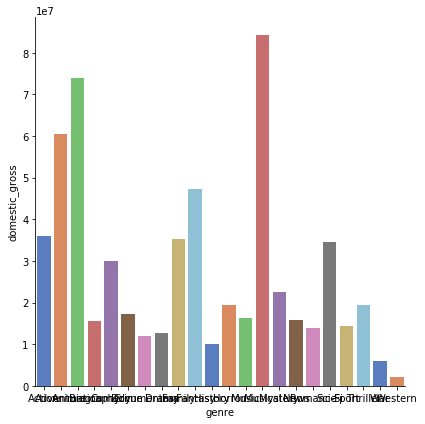

In [73]:
g = sns.catplot(x='genre', y="domestic_gross", data=groupedmed,
                height=6, kind="bar", palette="muted")